# Loading libraries and data

In [4]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from scipy import stats
from tqdm.auto import tqdm, trange
from networkx.algorithms import bipartite

In [8]:
g = nx.read_gexf('../graph.gexf')

# Preprocessing

## Removing super-mods 

Let's try to identify supermods. Even if they aren't bots, they moderate so many subs that they can't possibly pay attention to all of them. Edges due to them aren't meaningful.

In [11]:
mod_nodes = {n for n, d in g.nodes(data=True) if d["bipartite"] == 0}

In [12]:
n_moderated = [len(g.edges(n)) for n in mod_nodes]

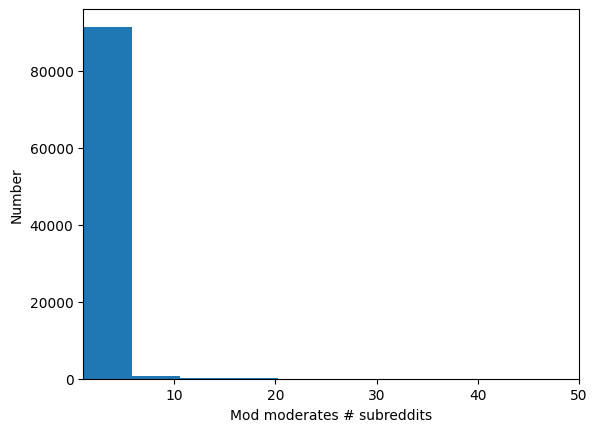

In [13]:
plt.hist(n_moderated, bins=50)
plt.xlim([1, 50])
plt.xlabel("Mod moderates # subreddits")
plt.ylabel("Number");

In [14]:
stats.percentileofscore(n_moderated, 15)

99.77130281880063

By removing all moderators that moderate > 15 subs, we'd only be removing 0.23% of all moderators, but 79.2% of all edges.

In [23]:
mods_to_remove = {n for n in mod_nodes if len(g.edges(n)) > 15}
g.remove_nodes_from(mods_to_remove)

Removing edges has split our graph into isolated connected components.

In [31]:
isolates = list(nx.connected_components(g))
len(isolates)

11802

In [59]:
isolates_size = sorted([len(iso) // 2 for iso in isolates], reverse=True)
isolates_size[0], isolates_size[1], sum(isolates_size[2:])

(30183, 47, 26215)

So we have 11'802 components. Of these, there is one giant component of 30'183 subs, and other smaller components comprising in total 26'262 subs.

## Computing edge conductivity

We also compute edge conductivity, where the conductivity of an edge is equal to $1/(\text{\# subs that this mod moderates})$. We will use this metric later on to compute [Resistance Distance](https://en.wikipedia.org/wiki/Resistance_distance).

In [164]:
edge_conductivity = dict()
sub_n_members = nx.get_node_attributes(g, "size")
for mod, sub in g.edges:
    edge_conductivity[(mod, sub)] = 1 / len(g.edges(mod))

In [165]:
nx.set_edge_attributes(g, edge_conductivity, 'conductivity')

# Exploration

My strategy is as follows. I will be using [Resistance Distance](https://en.wikipedia.org/wiki/Resistance_distance) to rank subs in order of relevance.

However, computing the resistance distance is slow, so instead of running it on the whole graph, I will select a group of nodes around my subreddit of interest (aka the **locality**). I will then rank those candidates using the resistance distance as a metric.

In [177]:
def get_locality(path_lengths, s0, max_loc_size):
    #increasing maximum path length from s0 to nodes until I reach my desired locality size
    max_length = 0
    curr_locality = [s0]
    next_locality = [u for u in path_lengths if path_lengths[u] < max_length * 2]
    
    while len(next_locality) < max_loc_size and len(next_locality) < len(path_lengths):
        max_length += 1
        curr_locality = next_locality
        next_locality = [u for u in path_lengths if path_lengths[u] < max_length * 2]

    return curr_locality

Let's explore an interesting subreddit called [r/hebrew](https://www.reddit.com/r/hebrew).

In [178]:
s0 = 'hebrew'

In [179]:
path_lengths = nx.shortest_path_length(g, source=s0)
locality = get_locality(path_lengths, s0, max_loc_size=5000)

In [183]:
#a subgraph covering our locality
g_local = g.subgraph(locality)

In [181]:
%time res_dist = nx.resistance_distance(g_local, nodeA=s0, weight='conductivity')

CPU times: user 1min 23s, sys: 23.3 s, total: 1min 46s
Wall time: 15.6 s


Now let's select the nodes.

In [169]:
mod_nodes = {n for n, d in g_local.nodes(data=True) if d["bipartite"] == 0}
sub_nodes = {n for n, d in g_local.nodes(data=True) if d["bipartite"] == 1}

In [249]:
candidate_subs = [k for k in res_dist.keys() if k in sub_nodes]
#`sorted` is a stable sort
candidate_subs = sorted(candidates, key=res_dist.get)
candidate_subs = sorted(candidate_subs, key=path_lengths.get)
#keeping top-20
candidate_subs = candidate_subs

In [250]:
for s in candidate_subs:
    print(s, path_lengths[s], res_dist[s])

hebrew 0 0.0
Yiddish 2 195.54789382586608
Judaism 2 344.58383222971
Wildlife 2 372.21935964024794
burgers 2 394.79357793931786
Ranching 2 411.3654248417137
analytics 2 421.1083133076957
snowden 4 417.7020580707556
nature 4 431.0969639883031
organic 4 438.57274098789117
lifeaquatic 4 446.11451423970516
Shipwrecks 4 480.30419558679347
paleonews 4 480.3041955867943
RenewableEnergy 4 505.5326100949415
veg 4 517.9617038201748
Jewish 4 520.9441900150788
hotdogs 4 561.4198430456763
BeforeNAfterAdoption 4 561.4198430456773
bigseo 4 668.8325927371208
missouri 4 759.1876328738066
marketing 4 877.4874290061698
Pinterest 4 1014.7950910940602
forestry 4 1411.3654248416838
SummerReddit 6 408.7054282864516
NotaMethAddict 6 415.995671836621
Documentaries 6 418.86101892099407
AntiTrumpAlliance 6 425.82830937635464
conservativeterrorism 6 429.4899848738087
Republican_misdeeds 6 437.58164452733763
rpg 6 439.57741075946643
UkraineWarRoom 6 446.09800674226744
Pareidolia 6 452.37607382974693
wikipedia 6 459

In [245]:
candidate_mods = list()
for mod in mod_nodes:
    inter = set(g.neighbors(mod)) &  set(candidate_subs)
    if len(inter) > 1:
        candidate_mods.append(mod)

We next write out our graph and visualise it in Gephi.

In [247]:
candidate_nodes = candidate_subs + candidate_mods
nx.write_gexf(g_local.subgraph(candidate_nodes), 'example.gexf')

The result:

![img](example.png)